In [4]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
import shapely
from shapely.geometry import Point, Polygon, LineString, LinearRing
from shapely import oriented_envelope, affinity
import math
from tqdm import tqdm
 
# prints parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


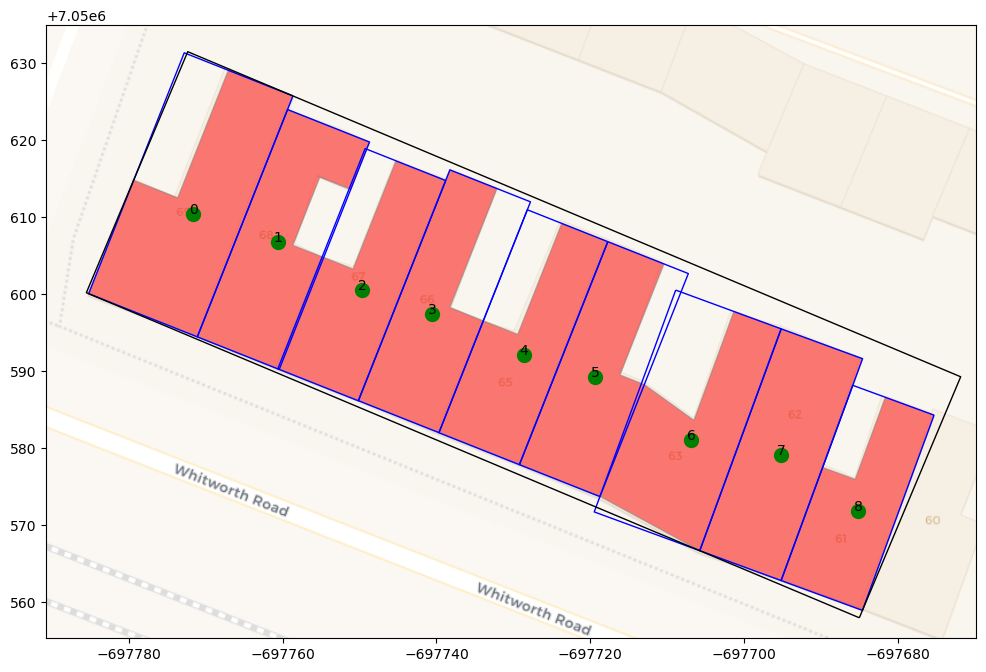

In [5]:
gdf = gpd.read_file(f'{parent_dir}/geojson_polygons/whitworth_buildings.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(12,8))
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
gdf['name'] = [idx for idx in range(len(gdf))]

gdf_subset = gdf.iloc[933:942].reset_index(drop=True)
gdf_subset['mbr'] = gdf_subset['geometry'].apply(lambda x: oriented_envelope(x))

new_933 = gdf_subset.iloc[0]['geometry']
gdf_subset['name'] = [idx for idx in range(len(gdf_subset))]

gdf_subset.plot(ax=ax, edgecolor='grey', facecolor='red', alpha=0.5)
gdf_subset['mbr'].plot(ax=ax, edgecolor='blue', facecolor='none')
gdf_subset['geometry'].centroid.plot(ax=ax, color='green', markersize=100)


#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

gdf_subset.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

oriented_envelope(gdf_subset.dissolve()['geometry']).plot(ax=ax, edgecolor='black', facecolor='none')

plt.show()

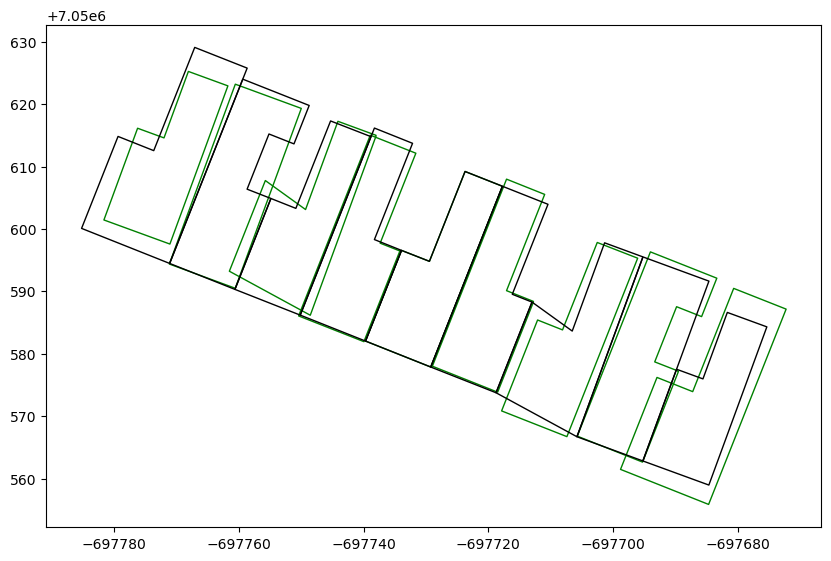

In [9]:
# this function nicely takes in A: a gdf polygons (with or without extra columns) and translates their positions to a centroid in the corresponding row of gdf B
def move_gdf(gdf_poly, gdf_p):
    gdf_new = gdf_poly.copy()
    gdf_new['delta_x'] = gdf_p['geometry'].x - gdf_new['geometry'].centroid.x
    gdf_new['delta_y'] = gdf_p['geometry'].y - gdf_new['geometry'].centroid.y
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.translate(gdf.loc['geometry'], xoff=gdf.loc['delta_x'], yoff=gdf.loc['delta_y']), axis=1)
    return gdf_new[gdf_new['geometry'].geom_type != 'Point']

def move_poly(poly, dest):
    x_old, y_old = poly.centroid.x, poly.centroid.y

    delta_x = dest.x - x_old
    delta_y = dest.y - y_old

    poly_new = affinity.translate(poly, xoff=delta_x, yoff=delta_y)

    return poly_new

points_new = gpd.GeoDataFrame(pd.DataFrame(gdf_subset['geometry'].centroid.reset_index(drop=True), columns=['geometry']).sort_index(ascending=False).reset_index(drop=True), geometry='geometry')

test_gdf = move_gdf(gdf_subset.reset_index(drop=True), points_new)

fig, ax = plt.subplots(1,1,figsize=(10,8))

test_gdf.plot(ax=ax, edgecolor='green', facecolor='none')
gdf_subset.plot(ax=ax, edgecolor='black', facecolor='none')

plt.show()


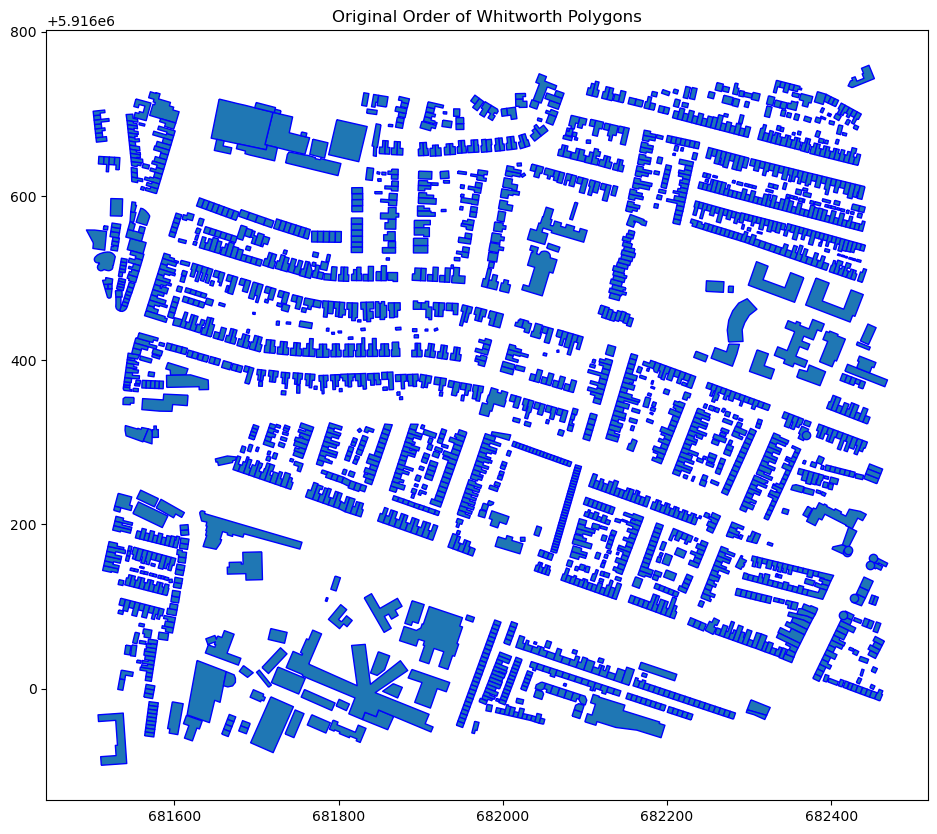

In [10]:
# let's try doing a shuffle of a full set of polygons, using the function we've created above

whitworth = gpd.read_file(f'{parent_dir}/geojson_polygons/whitworth_buildings.geojson')
whitworth = whitworth[whitworth['geometry'].geom_type == 'Polygon']
convert = True
if convert and whitworth.crs == 'EPSG:4326':
    whitworth = gdf.to_crs(32629) #UTM for Dublin

fig, ax = plt.subplots(1,1,figsize=(20,10))
whitworth.plot(ax=ax, edgecolor='blue')
ax.set_title("Original Order of Whitworth Polygons")

plt.show()

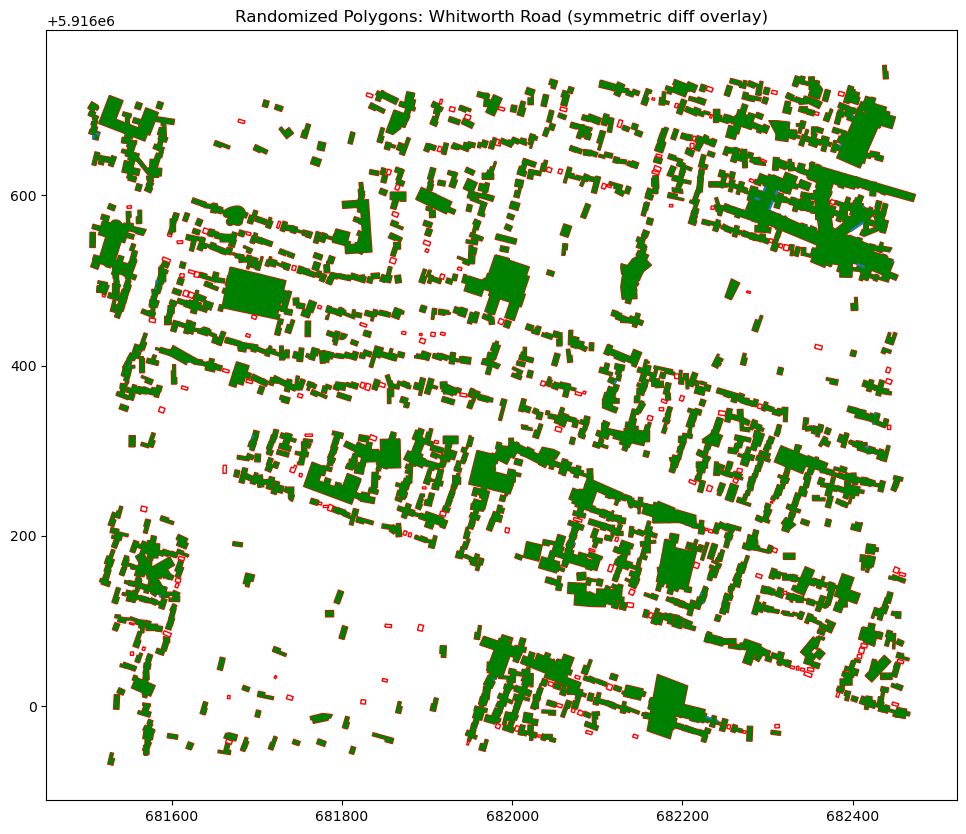

In [48]:
seed = 123
# taking the centroids of the polygons, and flipping the order of them
whitworth_move = gpd.GeoDataFrame(geometry=whitworth['geometry'].centroid, crs=whitworth.crs).sort_index(ascending=False).sample(frac = 1, random_state=seed).reset_index(drop=True)

whitworth_shuffle = move_gdf(whitworth, whitworth_move)

dis_whitworth = gpd.GeoDataFrame(geometry=list(whitworth_shuffle.dissolve().geometry[0].geoms),crs=whitworth_shuffle.crs)
dis_whitworth['area'] = dis_whitworth.apply(lambda x: x.area)

dis_whit_med = dis_whitworth[dis_whitworth['area'] > np.median(dis_whitworth['area'])/2]
step_1 = whitworth_shuffle.overlay(dis_whit_med, how='intersection')
step_2 = step_1.overlay(step_1, how='union', keep_geom_type=False)

fig, ax = plt.subplots(1,1,figsize=(15,10))

whitworth_shuffle.plot(ax=ax, edgecolor='red', facecolor='none')
#whitworth_shuffle.overlay(dis_whit_med, how='intersection').plot(ax=ax, facecolor='blue',edgecolor='black')
step_2.plot(ax=ax, facecolor='green')


ax.set_title("Randomized Polygons: Whitworth Road (symmetric diff overlay)")

plt.show()